2025-05-14 18:45:26.524346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747248326.778938      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747248326.851169      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Balancing classes...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-14 18:48:27.463818: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 302s 879ms/step - accuracy: 0.4108 - loss: 1.8304 - val_accuracy: 0.2739 - val_loss: 1.5281
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 284s 841ms/step - accuracy: 0.6250 - loss: 0.9287 - val_accuracy: 0.7026 - val_loss: 0.7377
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 299s 886ms/step - accuracy: 0.6647 - loss: 0.8341 - val_accuracy: 0.7073 - val_loss: 0.6963
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 290s 857ms/step - accuracy: 0.6864 - loss: 0.7758 - val_accuracy: 0.6998 - val_loss: 0.6948
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 296s 876ms/step - accuracy: 0.6860 - loss: 0.7595 - val_accuracy: 0.7008 - val_loss: 0.6839
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 286s 847ms/step - accuracy: 0.7027 - loss: 0.7140 - val_accuracy: 0.7073 - val_loss: 0.6716
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 280s 828ms/step - accuracy: 0.7010 - loss: 0.6972 - val_accuracy: 0.6942 - val_loss: 0.6791
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 293s 867ms/step - accuracy: 0.7098 -

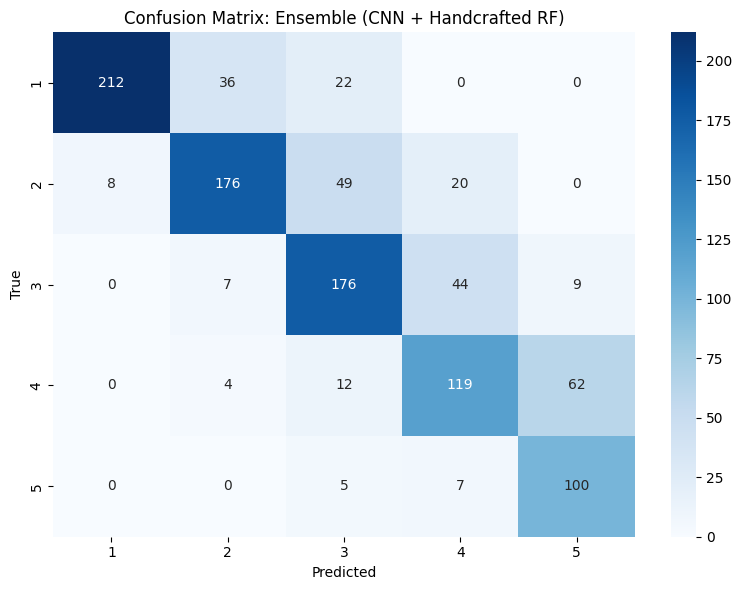


CNN Inference Time: 6.43s | FPS: 165.99

Overall AUC Score (Macro): 0.9449
Overall AUC Score (Micro): 0.9497

Mean Average Precision (mAP): 0.7893

Per-Class Metrics:
1               | Precision: 0.9636 | Recall: 0.7852 | F1-score: 0.8653
2               | Precision: 0.7892 | Recall: 0.6957 | F1-score: 0.7395
3               | Precision: 0.6667 | Recall: 0.7458 | F1-score: 0.7040
4               | Precision: 0.6263 | Recall: 0.6041 | F1-score: 0.6150
5               | Precision: 0.5848 | Recall: 0.8929 | F1-score: 0.7067


In [1]:
# === IMPORTS ===
import os, cv2, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import albumentations as A
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.filters import sobel, gabor

# === PATHS ===
train_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
val_dir   = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/val/images'
test_dir  = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

# === PARAMETERS ===
IMG_SIZE = 128
RESNET_SIZE = 224

# === LOAD IMAGES ===
def load_images(folder, img_size):
    paths = glob(os.path.join(folder, '*.jpg'))
    X, y = [], []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        label = os.path.basename(p).split("_")[-2]
        X.append(img)
        y.append(label)
    return np.array(X), np.array(y)

# === AUGMENTATION ===
augment = A.Compose([
    A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5), A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3), A.CLAHE(p=0.2), A.GaussNoise(p=0.3),
    A.HueSaturationValue(p=0.3), A.GridDistortion(p=0.2)])

def augment_minority_classes(X, y, le):
    print("Balancing classes...")
    counts = Counter(y)
    max_count = max(counts.values())
    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [x for x, l in zip(X, y) if l == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=(img * 255).astype(np.uint8))['image'] / 255.0
            new_X.append(aug_img)
            new_y.append(label)
    return np.array(new_X), np.array(new_y)

# === FEATURE EXTRACTION ===
def extract_handcrafted_features(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    gray = rgb2gray(img)
    gray_u8 = (gray * 255).astype(np.uint8)
    hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), feature_vector=True)
    lbp = local_binary_pattern(gray_u8, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp = hist_lbp.astype("float") / (hist_lbp.sum() + 1e-7)
    glcm = graycomatrix(gray_u8, [1], [0], 256, symmetric=True, normed=True)
    glcm_props = [graycoprops(glcm, p)[0, 0] for p in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]
    hu = cv2.HuMoments(cv2.moments(gray_u8)).flatten()
    sobel_edge = sobel(gray)
    sobel_hist, _ = np.histogram(sobel_edge.ravel(), bins=10, range=(0, 1))
    ssobel_hist = sobel_hist.astype('float32') / (sobel_hist.sum() + 1e-7)
    gabor_real, _ = gabor(gray, frequency=0.6)
    gabor_hist, _ = np.histogram(gabor_real.ravel(), bins=10, range=(0, gabor_real.max()))
    gabor_hist = gabor_hist.astype('float32') / (gabor_hist.sum() + 1e-7)
    return np.concatenate([hog_feat, hist_lbp, glcm_props, hu, sobel_hist, gabor_hist])

# === CNN MODEL ===
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape), BatchNormalization(), MaxPooling2D(),
        Conv2D(64, (3,3), activation='relu'), BatchNormalization(), MaxPooling2D(),
        Conv2D(64, (3,3), activation='relu'), BatchNormalization(), MaxPooling2D(),
        Flatten(), Dense(256, activation='relu'), Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# === DATA LOAD ===
X_train, y_train = load_images(train_dir, IMG_SIZE)
X_val, y_val = load_images(val_dir, IMG_SIZE)
X_test, y_test = load_images(test_dir, IMG_SIZE)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# === BALANCE ===
X_train_bal, y_train_bal = augment_minority_classes(X_train, y_train, le)
y_train_cat = to_categorical(le.transform(y_train_bal))
y_val_cat = to_categorical(y_val_enc)
y_test_cat = to_categorical(y_test_enc)

# === CNN TRAINING ===
cnn_model = build_cnn((IMG_SIZE, IMG_SIZE, 3), len(le.classes_))
cnn_model.fit(X_train_bal, y_train_cat, validation_data=(X_val, y_val_cat),
              epochs=10, batch_size=32, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=1)
cnn_probs = cnn_model.predict(X_test)


# === HANDCRAFTED + RF ===
X_train_hand = np.array([extract_handcrafted_features(img) for img in X_train_bal])
X_test_hand = np.array([extract_handcrafted_features(img) for img in X_test])
scaler = StandardScaler()
X_train_hand_scaled = scaler.fit_transform(X_train_hand)
X_test_hand_scaled = scaler.transform(X_test_hand)

rf_hand = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
rf_hand.fit(X_train_hand_scaled, le.transform(y_train_bal))
hand_probs = rf_hand.predict_proba(X_test_hand_scaled)

# === WEIGHTED SOFT VOTING ===
# Weight based on performance (assumed/estimated manually or via validation)
weights = [0.6, 0.4]  # [CNN, handcrafted]

# Compute ensemble probabilities (CNN + RF)
ensemble_probs = (weights[0] * cnn_probs +
                  weights[1] * hand_probs)

# Final prediction
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# === EVALUATION ===
print("\n Final Ensemble Report (CNN + RF Handcrafted Only):")
print(classification_report(y_test_enc, ensemble_preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_enc, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: Ensemble (CNN + Handcrafted RF)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
import time

# === One-hot encode true labels for AUC/mAP ===
y_test_true_oh = to_categorical(y_test_enc, num_classes=len(le.classes_))

# === Inference time & FPS ===
start_time = time.time()
_ = cnn_model.predict(X_test, verbose=0)
cnn_time = time.time() - start_time
fps = len(X_test) / cnn_time
print(f"\nCNN Inference Time: {cnn_time:.2f}s | FPS: {fps:.2f}")

# === AUC (Overall) ===
auc_macro = roc_auc_score(y_test_true_oh, ensemble_probs, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_true_oh, ensemble_probs, average='micro', multi_class='ovr')
print(f"\nOverall AUC Score (Macro): {auc_macro:.4f}")
print(f"Overall AUC Score (Micro): {auc_micro:.4f}")

# === mAP ===
mAP = average_precision_score(y_test_true_oh, ensemble_probs, average='macro')
print(f"\nMean Average Precision (mAP): {mAP:.4f}")

# === Per-Class Precision & F1 ===
prec, recall, f1, _ = precision_recall_fscore_support(y_test_enc, ensemble_preds, labels=np.arange(len(le.classes_)))

print("\nPer-Class Metrics:")
for i, cls in enumerate(le.classes_):
    print(f"{cls:15s} | Precision: {prec[i]:.4f} | Recall: {recall[i]:.4f} | F1-score: {f1[i]:.4f}")
